# NAMES: Timothy Barao, Marlan McInnes-Taylor
# FSUIDS: tjb13b, mm05f

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from numpy import linalg as LA

In [2]:
class FSA:
    def __init__(self, xt, yt, xv, yv):
        self.load_data(xt, yt, xv, yv)
        
        self.s = 0.001
        self.u = 50 
        self.N_iter = 500
        self.lr = 0.01      

        self.M = self.x_t.shape[1]
        self.N = self.x_t.shape[0]
        self.B = np.zeros(self.M)
        
        self.losses = []
     
    def load_data(self, x_train_file, y_train_file, x_valid_file, y_valid_file):
        if "dexter" in x_train_file:
            self.x_t = np.loadtxt(x_train_file, delimiter=',')
            self.x_v = np.loadtxt(x_valid_file, delimiter=',')
        else:
            self.x_t = np.loadtxt(x_train_file)
            self.x_v = np.loadtxt(x_valid_file)
        
        self.y_t = np.loadtxt(y_train_file) 
        self.y_v = np.loadtxt(y_valid_file) 
        
        #print(self.y_v.shape)
        #print(self.y_t.shape)
                              
        self.N = self.x_t.shape[0]   # Rows
        self.M = self.x_t.shape[1]   # Columns 

        mx = np.mean(self.x_t, axis = 0)
        sx = np.std(self.x_t, axis = 0)
        sx[sx == 0] = 0.00001
        self.x_t = (self.x_t - mx)/sx
        
        mx = np.mean(self.x_v, axis = 0)
        sx = np.std(self.x_v, axis = 0)
        sx[sx == 0] = 0.00001
        self.x_v = (self.x_v - mx) / sx
 
        self.print_features()
              
    def gradient_update(self):  
        xw = np.matmul(self.x_t, self.B)
        yxw = self.y_t * xw
        
        N,d=self.x_t.shape
        
        ly= 2 * (yxw - 1) / (1 + (yxw - 1) ** 2) * self.y_t
        ydx=np.matmul(ly.T,self.x_t)
        g=ydx.T/N+2*self.s*self.B
        
        self.B = self.B - self.lr * g
        loss = self.loss()
        #print(loss)

        return loss
    
    def loss(self):
        xB = np.matmul(self.x_t, self.B)
        yBx = self.y_t * xB

        temp = np.log(1 + (yBx - 1)**2)
        temp[yBx > 1] = 0
        lo = np.mean(temp)
        grad = lo + (self.s * np.sum(self.B ** 2))
        
        return grad

    def predict(self):
        xw=np.matmul(self.x_t, self.B)
        yxw=self.y_t*xw
        
        x_w=np.matmul(self.x_v, self.B)
        y_xw=self.y_v*x_w
        return np.mean(yxw<=0), np.mean(y_xw<=0)
        
        
        xB = np.matmul(self.x_t, self.B)
        yPred = np.sign(xB)
        trainAcc = 1- np.mean(yPred == self.y_t.flatten())
        
        xB = np.matmul(self.x_v, self.B)
        yPred = np.sign(xB)
        testAcc = 1 - np.mean(yPred == self.y_v.flatten())
        
        return trainAcc, testAcc
    
    def train(self, k):
        mPrev = self.M
        for i in range(0, self.N_iter):
            if k == 30:
                loss = self.gradient_update()
                self.losses.append(loss)
            else:
                self.gradient_update()
            
            temp = (self.N_iter - 2 * i)/(2 * i * self.u + self.N_iter)
            temp = max(0, temp)
            mi = k + (self.M - k) * temp
            mi = int(mi)
            
            if mi < mPrev:
                indc = np.absolute(self.B)
                sort = np.argsort(indc)
                sort = sort[-mi:]
                self.B=self.B[sort]
                self.x_t=(self.x_t.T[sort]).T
                self.x_v=(self.x_v.T[sort]).T
                mPrev = mi
                self.M = mi
    
    def print_features(self):
        print("\n=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=")
        print("X_train Objs: ", self.x_t.shape[0], "X_train Feats: ", self.x_t.shape[1])
        print("Y_train Objs: ", self.y_t.shape[0])
        print("\nX_valid Objs: ", self.x_v.shape[0], "X_valid Feats: ", self.x_v.shape[1])
        print("Y_valid Objs: ", self.y_v.shape[0])
        print("=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=")

In [3]:
K = [10, 30, 100, 300, 500]
trainErrors = []
testErrors = []
losses = []

# Madelon

In [4]:
x_train_file = "../data/MADELON/madelon_train.data"
y_train_file = "../data/MADELON/madelon_train.labels"

x_valid_file = "../data/MADELON/madelon_valid.data"
y_valid_file = "../data/MADELON/madelon_valid.labels"

In [5]:
for k in K:
    model = FSA(x_train_file, y_train_file, x_valid_file, y_valid_file)
    model.train(k)
    if k == 30:
        xVals = np.arange(0, model.N_iter)
        losses = model.losses
    trainAccuracy, testAccuracy = model.predict()
    trainErrors.append(round((trainAccuracy) * 100, 2))
    testErrors.append(round((testAccuracy) * 100, 2))
print("Train Errors: ", trainErrors)
print("Test Errors: ", testErrors)
print(np.array(losses).shape)


=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=
X_train Objs:  2000 X_train Feats:  500
Y_train Objs:  2000

X_valid Objs:  600 X_valid Feats:  500
Y_valid Objs:  600
=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=

=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=
X_train Objs:  2000 X_train Feats:  500
Y_train Objs:  2000

X_valid Objs:  600 X_valid Feats:  500
Y_valid Objs:  600
=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=

=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=
X_train Objs:  2000 X_train Feats:  500
Y_train Objs:  2000

X_valid Objs:  600 X_valid Feats:  500
Y_valid Objs:  600
=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=

=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=
X_train Objs:  2000 X_train Feats:  500
Y_train Objs:  2000

X_valid Objs:  600 X_valid Feats:  500
Y_valid Objs:  600
=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=

=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=
X_train Objs:  2000 X_train Feats

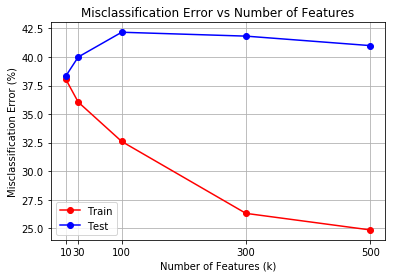

In [6]:
plt.plot(K, trainErrors, linestyle='-', marker='o', color='r', label='Train')
plt.plot(K, testErrors, linestyle='-', marker='o', color='b', label='Test')
plt.grid(True)
plt.xticks(K)
plt.title('Misclassification Error vs Number of Features')
plt.xlabel('Number of Features (k)')
plt.ylabel('Misclassification Error (%)')
plt.legend()
plt.show()


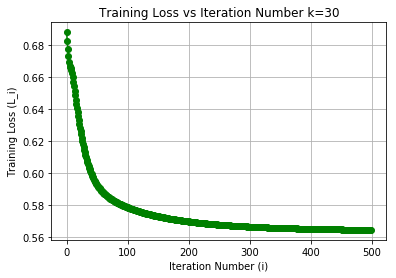

In [7]:
plt.plot(xVals, losses, linestyle='-', marker='o', color='g')
plt.grid(True)
plt.title('Training Loss vs Iteration Number k=30')
plt.xlabel('Iteration Number (i)')
plt.ylabel('Training Loss (L_i)')
plt.show()

In [8]:
errorTableMadelon = pd.DataFrame({"Training Error (%)":[0, 0, 0, 0, 0], "Test Error (%)":[0, 0, 0, 0, 0]}, index=K)
errorTableMadelon.index.name = "N Features"
for k, trainErr, testErr in zip(K, trainErrors, testErrors):
    errorTableMadelon.loc[k, 'Training Error (%)'] = trainErr
    errorTableMadelon.loc[k, 'Test Error (%)'] = testErr
    
errorTableMadelon

,Test Error (%),Training Error (%)
N Features,,
10,38.33,38.05
30,40.00,36.05
100,42.17,32.60
300,41.83,26.30
500,41.00,24.85


In [9]:
trainErrors.clear()
testErrors.clear()
losses = [] 

# Dexter

In [10]:
x_train_file = "../data/dexter/dexter_train.csv"
y_train_file = "../data/dexter/dexter_train.labels"

x_valid_file = "../data/dexter/dexter_valid.csv"
y_valid_file = "../data/dexter/dexter_valid.labels"

In [ ]:
for k in K:
    model = FSA(x_train_file, y_train_file, x_valid_file, y_valid_file)
    model.train(k)
    if k == 30:
        xVals = np.arange(0, model.N_iter)
        losses = model.losses
    trainAccuracy, testAccuracy = model.predict()
    trainErrors.append(round((trainAccuracy) * 100, 2))
    testErrors.append(round((testAccuracy) * 100, 2))
print("Train Errors: ", trainErrors)
print("Test Errors: ", testErrors)
print(np.array(losses).shape)

In [ ]:
plt.plot(xVals, losses, linestyle='-', marker='o', color='g')
plt.grid(True)
plt.title('Training Loss vs Iteration Number k=30')
plt.xlabel('Iteration Number (i)')
plt.ylabel('Training Loss (L_i)')
plt.show()

In [ ]:
plt.plot(K, trainErrors, linestyle='-', marker='o', color='r', label='Train')
plt.plot(K, testErrors, linestyle='-', marker='o', color='b', label='Test')
plt.grid(True)
plt.xticks(K)
plt.title('Misclassification Error vs Number of Features')
plt.xlabel('Number of Features (k)')
plt.ylabel('Misclassification Error (%)')
plt.legend()
plt.show()

In [ ]:
errorTableDexter = pd.DataFrame({"Training Error (%)":[0, 0, 0, 0, 0], "Test Error (%)":[0, 0, 0, 0, 0]}, index=K)
errorTableDexter.index.name = "N Features"
for k, trainErr, testErr in zip(K, trainErrors, testErrors):
    errorTableDexter.loc[k, 'Training Error (%)'] = trainErr
    errorTableDexter.loc[k, 'Test Error (%)'] = testErr
    
errorTableDexter

In [ ]:
trainErrors.clear()
testErrors.clear()
losses = []

# Gisette 

In [ ]:
x_train_file = "../data/Gisette/gisette_train.data"
y_train_file = "../data/Gisette/gisette_train.labels"

x_valid_file = "../data/Gisette/gisette_valid.data"
y_valid_file = "../data/Gisette/gisette_valid.labels"

In [ ]:
for k in K:
    model = FSA(x_train_file, y_train_file, x_valid_file, y_valid_file)
    model.train(k)
    if k == 30:
        xVals = np.arange(0, model.N_iter)
        losses = model.losses
    trainAccuracy, testAccuracy = model.predict()
    trainErrors.append(round((trainAccuracy) * 100, 2))
    testErrors.append(round((testAccuracy) * 100, 2))
print("Train Errors: ", trainErrors)
print("Test Errors: ", testErrors)
print(np.array(losses).shape)

In [ ]:
plt.plot(xVals, losses, linestyle='-', marker='o', color='g')
plt.grid(True)
plt.title('Training Loss vs Iteration Number k=30')
plt.xlabel('Iteration Number (i)')
plt.ylabel('Training Loss (L_i)')
plt.show()

In [ ]:
plt.plot(K, trainErrors, linestyle='-', marker='o', color='r', label='Train')
plt.plot(K, testErrors, linestyle='-', marker='o', color='b', label='Test')
plt.grid(True)
plt.xticks(K)
plt.title('Misclassification Error vs Number of Features')
plt.xlabel('Number of Features (k)')
plt.ylabel('Misclassification Error (%)')
plt.legend()
plt.show()

In [ ]:
errorTableGisette = pd.DataFrame({"Training Error (%)":[0, 0, 0, 0, 0], "Test Error (%)":[0, 0, 0, 0, 0]}, index=K)
errorTableGisette.index.name = "N Features"
for k, trainErr, testErr in zip(K, trainErrors, testErrors):
    errorTableGisette.loc[k, 'Training Error (%)'] = trainErr
    errorTableGisette.loc[k, 'Test Error (%)'] = testErr
    
errorTableGisette

In [ ]:
#u corresponding to the correct class

#u_y - u_k
#prediction of class - prediction of the other class
#pyTorch for gradient
'''
optim.SGD
optimizer.zero_grad()
outputs = net(inputs)
loss = torch.sum()#
loss.backward()
optimizer.step()
'''

class Net(nn.Module):
    def __init__(self, ):
        self.fc1 = nn.Linear(5000, 1, bias=False)
    def forward(self, x):
        x = self.fc1(x)
        return x
    
net = Net()
net.fc1.weight=nn.Parameter(torch.zeros(1, 5000), requires_grad=)
  
criterion = nn.MSELoss(reduction='sum')
optimizer = optim.SGD(net.parameters(), lr=0.01)   

xx = torch.from_numpy(x.astype(np.float32))
yy = torch.from_numpy(y.astype(np.int)))

for i in range(30):
    inputs = xx
    labels = yy
    
    optimizer.zero_grad()
    outputs = net(inputs)
    u = yy * outputs
    loss = torch.mean(torch.log(1+F.relu(1 - u)**2))
    loss.backward()
    optimizer.step()
    
    running_loss = loss.item()
    
    

In [ ]:
  a